<a href="https://colab.research.google.com/github/mmazzolini/DL_discharge_prediction/blob/main/SAN_BENIGNO__30_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import sys, importlib
importlib.reload(sys.modules['classic_CV_predict'])

## Convolutionl neural network training

### SAN BENIGNO GAUGING STATION, ORCO BASIN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/mmazzolini/DL_discharge_prediction.git

Cloning into 'DL_discharge_prediction'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 45 (delta 3), reused 29 (delta 2), pack-reused 15
Unpacking objects: 100% (45/45), done.
Checking out files: 100% (25/25), done.


In [5]:
!pip install geopandas


     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 45.2 MB/s 
     |████████████████████████████████| 15.4 MB 44.3 MB/s 


In [22]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch as T
#from skorch import NeuralNetRegressor
import datetime

import numpy as np
import imageio
import torch.utils.data as data_utils

from sklearn.model_selection import TimeSeriesSplit

import sys
sys.path.insert(0, "/content/DL_discharge_prediction")
from sf_runoff import create_in_m, shift_series_

import pandas as pd
import seaborn as sns
import pdb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

### DATA IMPORT AND PREPROCESSING

In [7]:
discharge = pd.read_csv('/content/drive/MyDrive/DL/input_discharge/ADO_DSC_ITC1_0027.csv', header=[0], index_col=[0])
discharge.index = pd.to_datetime(discharge.index)
discharge = discharge.rolling(30, min_periods=30).mean()[30:]

In [8]:
#daily_input = pd.read_csv(path+'DROME_SAILLANS.csv', index_col=0, parse_dates=True)
daily_input = pd.read_csv('/content/drive/MyDrive/DL/daily_input_cube/ADO_DSC_ITC1_0027.csv', header=[0,1,2], index_col=[0])
daily_input.index = pd.to_datetime(daily_input.index )

y_len = daily_input.columns.levels[0].shape[0]
x_len = daily_input.columns.levels[1].shape[0]

t_length=12
t_unit=30
in_matrix = create_in_m(daily_input,t_length,t_unit)

new_names=daily_input.columns.names.copy()
#+('t_ago'),)
new_names.append('t_ago')
#index = pd.MultiIndex.from_product([daily_input.columns.levels[0].values,daily_input.columns.levels[1].values, ['T', 'P', 'E', 'S'],np.arange(-t_length+1,1)],names=['y','x','var','t_ago'])
in_matrix.columns.names=new_names



In [9]:
date_disch=pd.to_datetime(discharge.index)
date_meteo=pd.to_datetime(in_matrix.index)

c = [x for x in date_disch if x in date_meteo]


in_matrix=in_matrix.reindex(index = c)
discharge=discharge.reindex(index = c)
#print the last date
c[-1]

Timestamp('2019-11-26 00:00:00')

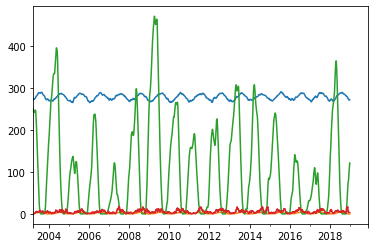

In [10]:
#normalize the output
discharge_std=np.nanstd(discharge)
discharge = discharge/discharge_std

#normalize each inpuT variable
T = in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='T']
shape=T.shape
T.loc[:,T.columns.get_level_values('t_ago')=='0'].mean(axis=1).plot()
T=np.array(T).reshape(-1)
T=(T-np.nanmean(T))/(np.nanstd(T))
in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='T']=T.reshape(shape)

E = in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='E']
shape=E.shape
E.loc[:,E.columns.get_level_values('t_ago')=='0'].mean(axis=1).plot()
E=np.array(E).reshape(-1)
E=(E)/(np.nanstd(E))
in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='E']=E.reshape(shape)

S = in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='S']
shape=S.shape
S.loc[:,S.columns.get_level_values('t_ago')=='0'].mean(axis=1).plot()
S=np.array(S).reshape(-1)
S=(S)/(np.nanstd(S))
in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='S']=S.reshape(shape)

P = in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='P']
shape=P.shape
P.loc[:,P.columns.get_level_values('t_ago')=='0'].mean(axis=1).plot()
P=np.array(P).reshape(-1)
P=(P)/(np.nanstd(P))
in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='P']=P.reshape(shape)

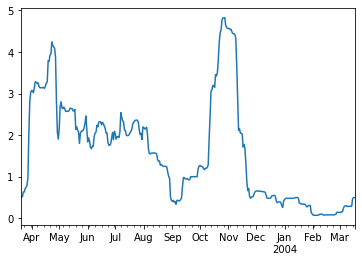

In [11]:
T = in_matrix.loc[:,in_matrix.columns.get_level_values('var')=='P']
shape=T.shape
T.loc[:,T.columns.get_level_values('t_ago')=='-11'].mean(axis=1)[0:365].plot()

In [12]:
in_array=np.array(in_matrix,dtype='float32').reshape(in_matrix.shape[0],4,y_len,x_len,t_length)
in_array=in_array.swapaxes(4,2)
in_array=in_array.swapaxes(4,3)
in_array=in_array.reshape(in_array.shape[0],4*t_length,y_len,x_len)
in_array=np.nan_to_num(in_array,copy=False)

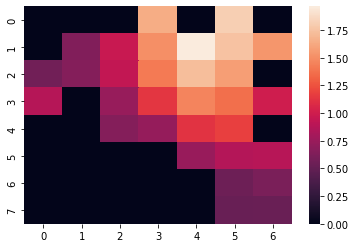

In [13]:
sns.heatmap(data=in_array[100,0,:,:])

In [15]:
# DISCARD THE LAST TWO YEARS, BECAUSE OF LOW DATA QUALITY

in_array=in_array[:-730]
discharge=discharge.iloc[:-730]

 ### DEFINE THE NETWORK

In [30]:
import torch as T
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

#define the model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(48,  48*15, kernel_size=3,stride=1,padding=1,groups=12)#add the groups parameter.
        self.conv2 = nn.Conv2d(48*15, 48*15, kernel_size=3,padding=1,groups=12)
        self.conv3 = nn.Conv2d(48*15, 48*15, kernel_size=3,padding=1,groups=12)
        self.fc1 = nn.Linear(48*15, 48*15)
        self.fc2 = nn.Linear(48*15, 48*8)
        self.fc3 = nn.Linear(48*8, 48*4)
        self.fc4 = nn.Linear(48*4, 48*4)

        self.fc5 = nn.Linear(48*4, 1)
        
    def forward(self, x):
        
        drop = T.nn.Dropout(p=0.08)
        drop_d = T.nn.Dropout(p=0.25)
        pool = nn.AvgPool2d(kernel_size=(2,2))
        pool2 = nn.AvgPool2d(kernel_size=(3,2))
        SELU= T.nn.SELU()
        RELU= T.nn.ReLU()


        x = SELU(self.conv1(x))
        #x = drop(x)
        x = SELU(pool(self.conv2(x)))
        #x = drop(x)
        x = SELU(pool2(self.conv3(x)))

        x = x.view(-1,48*15)
        
        x = SELU(self.fc1(x))
        #x = drop_d(x)
        x = SELU(self.fc2(x))
        #x = drop_d(x)
        x = SELU(self.fc3(x))
        #x = drop_d(x) 
        x = SELU(self.fc4(x))

        #x = drop_d(x)
        
        x = RELU(self.fc5(x))
        

        return x





In [31]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
%load_ext tensorboard
%tensorboard --logdir logs/tensorboard/san_b

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(48, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Conv2d(720, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Conv2d(720, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Linear(in_features=720, out_features=720, bias=True)
Reset trainable parameters of layer = Linear(in_features=720, out_features=384, bias=True)
Reset trainable parameters of layer = Linear(in_features=384, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=1, bias=True)


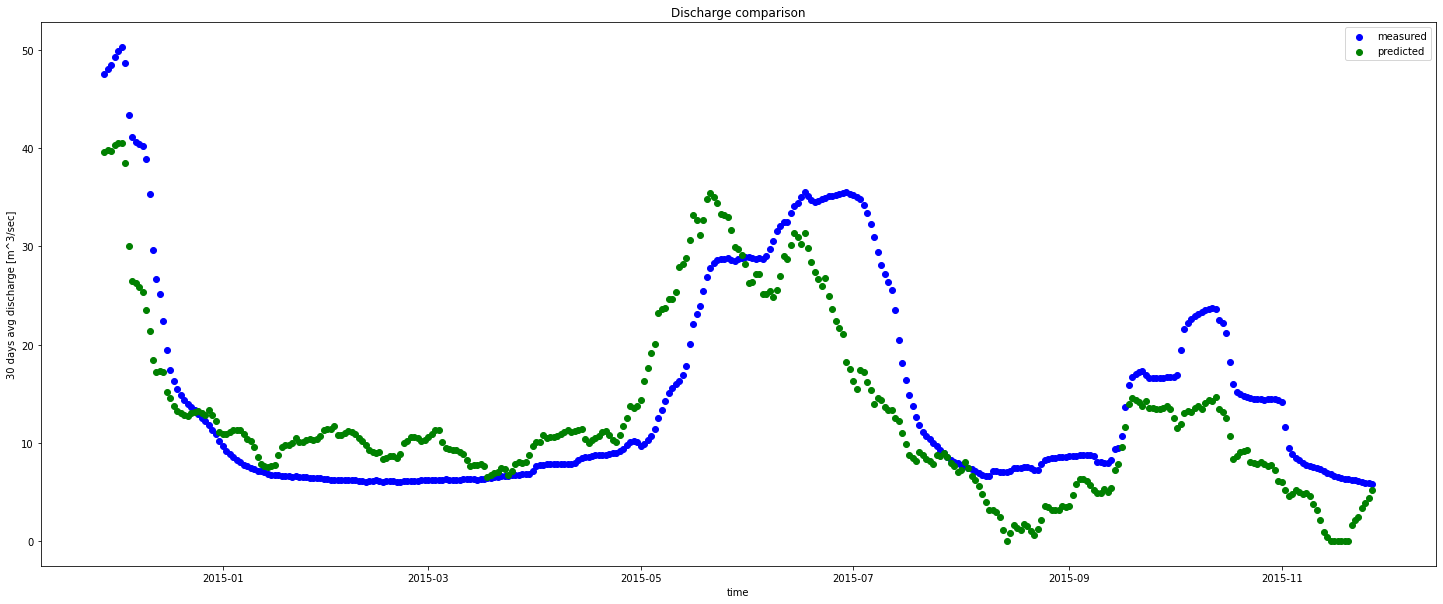

FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(48, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Conv2d(720, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Conv2d(720, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Linear(in_features=720, out_features=720, bias=True)
Reset trainable parameters of layer = Linear(in_features=720, out_features=384, bias=True)
Reset trainable parameters of layer = Linear(in_features=384, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=1, bias=True)


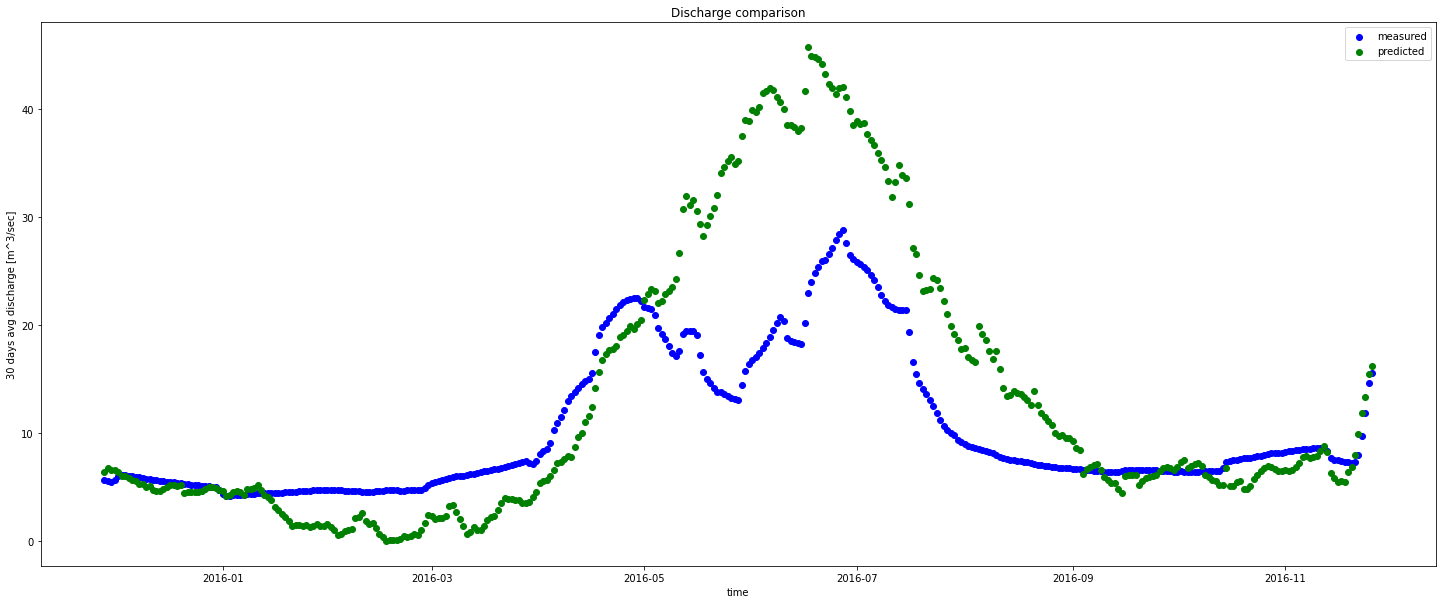

FOLD 2
--------------------------------
Reset trainable parameters of layer = Conv2d(48, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Conv2d(720, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Conv2d(720, 720, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=12)
Reset trainable parameters of layer = Linear(in_features=720, out_features=720, bias=True)
Reset trainable parameters of layer = Linear(in_features=720, out_features=384, bias=True)
Reset trainable parameters of layer = Linear(in_features=384, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=192, bias=True)
Reset trainable parameters of layer = Linear(in_features=192, out_features=1, bias=True)


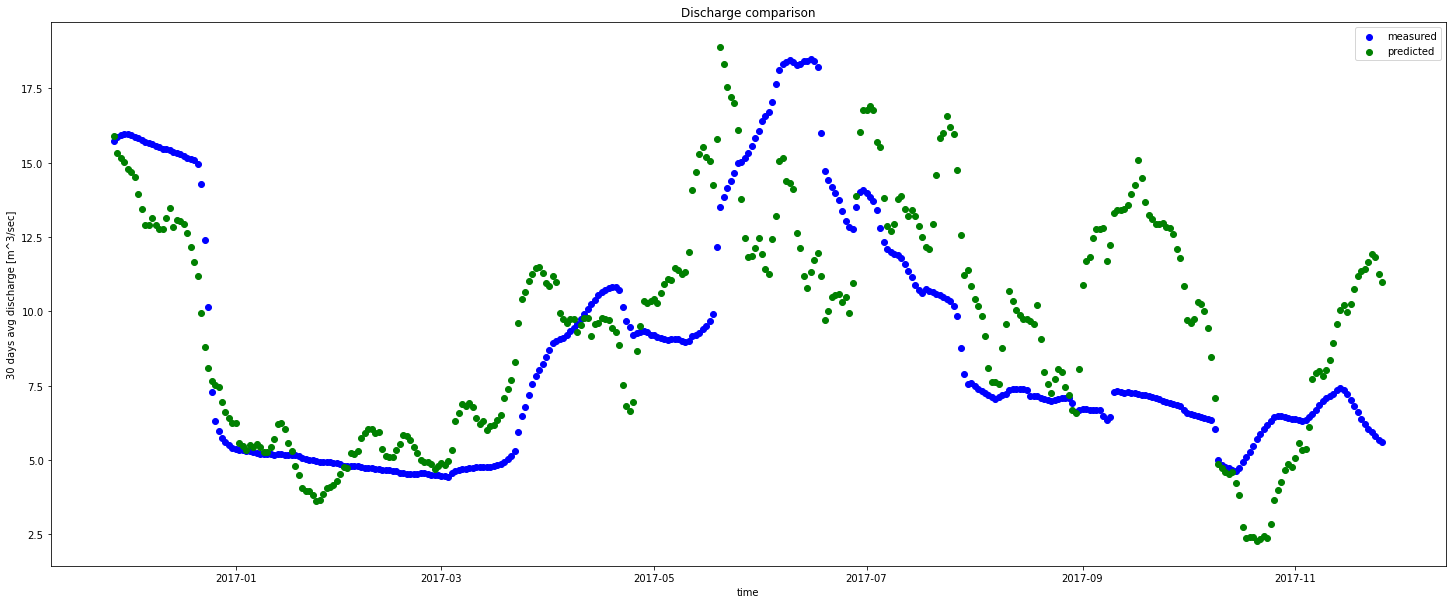

In [32]:
#define folds partition
test_size = 365
gap = 30
n_s = 3

#define training parameters
l_r = 0.0000015
w_d = 0.00000001
batch_size=32
n_e = 100

#define the sets
folds= TimeSeriesSplit(n_splits=n_s, test_size= test_size, gap=gap)

#initialize data structures
results = {}
prediction=pd.DataFrame(data=None)


for fold, (train_ids, test_ids) in enumerate(folds.split(in_array)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    #setup tensorboard reporting
    train_log_dir = 'logs/tensorboard/san_b/fold_' + str(fold)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    #define train and test sets

    X_train = torch.tensor(in_array[train_ids],device=device)
    y_train = torch.tensor(np.array(discharge.iloc[train_ids],dtype='float32').reshape(-1,1),device=device)
    train_tensor = data_utils.TensorDataset(X_train, y_train) 
    train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

    X_test = torch.tensor(in_array[test_ids],device=device)
    y_test = torch.tensor(np.array(discharge.iloc[test_ids],dtype='float32').reshape(-1,1),device=device)
    test_dates=discharge.iloc[test_ids].index
    """test_tensor = data_utils.TensorDataset(X_test, y_test) 
    test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)
    """

    # Construct our model by instantiating the class defined above
    model = CNN()
    model.apply(reset_weights)
    n_epochs=100

    model.to(device)

    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters (defined 
    # with torch.nn.Parameter) which are members of the model.

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=l_r, weight_decay=w_d)

    # epoch iteration
    for epoch in range(n_e):
        
        epoch_loss = 0.0
        test_loss = 0.0
        running_loss = 0.0

        #batch iteration
        for step, (batch_x, batch_y) in enumerate(train_loader): # for each training step

          X_t=Variable(batch_x)
          y_t=Variable(batch_y)

          #put model in train mode (droput active)
          model.train()

          # Forward pass: Compute predicted y by passing x to the model
          y_pred = model(X_t)

          # Compute and print loss
          loss = criterion(y_pred, y_t)

          # Zero gradients, perform a backward pass, and update the weights.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          #update the epoch loss
          epoch_loss += y_pred.shape[0] * loss.item()

          # print STEP statistics
          """
          running_loss += loss.item()
          if step % batch_size == (batch_size-1):    # print every 2000 mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, step + 1, running_loss / batch_size))
              running_loss = 0.0"""

        #set the model in evaluation mode
        model.eval()

        #predict the entire test
        y_pred_ev=model(X_test)

        #compute the loss
        test_loss = criterion(y_pred_ev, y_test)


        # This is where I'm recording to Tensorboard
        with train_summary_writer.as_default():
            tf.summary.scalar('train_loss', epoch_loss / X_train.shape[0], step=epoch)

        with train_summary_writer.as_default():
          tf.summary.scalar('test_loss', test_loss.item(),step=epoch)
        
        #print EPOCH statistics
        """
        # print epoch loss
        print(f'epoch:{epoch+1},train_loss = {epoch_loss / X_train.shape[0]} , test_loss = {test_loss.item()}')
        """

    # Saving the model
    save_path = f'/content/drive/MyDrive/DL/MODELS/SB-M1-{fold}.pth'
    torch.save(model.state_dict(), save_path)

    #print the prediction: MULTIPLY*DISCHARGE_STD

    plt.figure(figsize=(25,10))
    plt.scatter(test_dates, y_test.cpu().detach().numpy()*discharge_std, color = "blue",label = 'measured')
    plt.scatter(test_dates, y_pred_ev.cpu().detach().numpy()*discharge_std, color = "green",label='predicted')

    plt.title('Discharge comparison')
    plt.xlabel('time')
    plt.ylabel('30 days avg discharge [m^3/sec]')
    plt.legend()

    plt.show()

    #fill the prediction dataset
    target=pd.DataFrame(index=test_dates)
    target['meas_discharge']=y_test.cpu().detach().numpy().flatten()
    target['pred_discharge']=y_pred_ev.cpu().detach().numpy().flatten()
    
    prediction=prediction.append(target)

    #print(f'Result: {model}')
writer.close()

## MODEL EVALUATION

In [33]:
prediction=prediction*discharge_std
#compute the r^2 metric
discharge_error_r2=prediction.apply(lambda y_pred: r2_score(prediction['meas_discharge'], y_pred), axis=0)
discharge_error_r2

meas_discharge    1.000000
pred_discharge    0.387818
dtype: float64